In [154]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output

In [3]:
# load the data
train = datasets.MNIST("", train=True, download=True,
                          transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train=False, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))
# batch size
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [4]:
# create the neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(28*28, 64)
        # hidden layer
        self.fc2 = nn.Linear(64, 64)
        # output layer
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # output layer
        x = self.fc3(x)
        # softmax for probability distribution
        return F.log_softmax(x, dim=1)
    
net = Net()

In [161]:
# define function that creates targeted adversarial examples
def create_targeted_adversarial_examples(model, base_image, true_idx, target_class_idx, steps=100, epsilon=0.1):
    # set model to evaluation mode
    model.eval()
    # set requires_grad to true to get gradients
    #delta.requires_grad = True
    delta = torch.zeros_like(base_image, requires_grad=True)
    # set the optimizer
    optimizer = optim.Adam([delta], lr=0.1)
    perturbed_image = base_image + delta
    target_class_idx = torch.tensor([target_class_idx])
    #true_idx = torch.tensor([true_idx])
    true_idx = net.forward(base_image.view(-1, 28*28)).argmax(dim=1)
    # loop through the number of steps
    for i in range(steps):
        # get the output of the model
        output = model(perturbed_image)
        # get  the negative sparse categorical cross-entropy loss with respect to the original class label
        loss = -F.nll_loss(output, true_idx)
        # get the positive categorical cross-entropy loss with respect to the target class label
        loss += F.nll_loss(output, target_class_idx)
        # zero the gradients
        optimizer.zero_grad()
        # backpropagate
        loss.backward()
        # update the weights
        optimizer.step()
        # clamp the values of delta to the range of [-epsilon, epsilon]
        delta.data.clamp_(-epsilon, epsilon)
        # update the perturbed image
        perturbed_image = base_image + delta
    # detach the delta tensor from the computation graph
    delta.detach_()


    # return the perturbed image
    return perturbed_image

In [142]:
# define a function that finds the lowest epsilon value that results in a successful attack
def find_epsilon(model, base_image, true_idx, target_class_idx, steps=100, max_iter=10):
    epsilon_up = 1
    epsilon_down = 0
    with torch.no_grad():
        logs = model.forward(base_image)
    i = 0
    while (i < max_iter):
        epsilon = (epsilon_up + epsilon_down)/2
        perturbed_image = create_targeted_adversarial_examples(model, base_image, true_idx, target_class_idx, steps, epsilon)
        with torch.no_grad():
            logs = model.forward(perturbed_image)
        if (logs[0][true_idx] >= logs[0][target_class_idx]):
            epsilon_down = epsilon
        else:
            epsilon_up = epsilon
        i += 1
    return epsilon_up
        

In [147]:
# define function that finds margin-epsilon pairs on a given image
def margin_epsilons(model, base_image, true_idx, steps = 100, max_iter = 10):
    with torch.no_grad():
        logs = model.forward(base_image)
    margins = logs[0][true_idx] - logs[0]
    margins = margins.numpy()
    epsilons = []
    for i in range(10):
        epsilons.append(find_epsilon(model, base_image, true_idx, i, steps, max_iter))
    return margins, epsilons

In [6]:
# train the neural network
optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCHS = 3

for epoch in range(EPOCHS):
    for data in trainset:
        # data is a batch of featuresets and labels
        X, y = data
        # set the gradients to zero
        net.zero_grad()
        # forward pass
        output = net(X.view(-1, 28*28))
        # calculate the loss
        loss = F.nll_loss(output, y)
        # backward pass
        loss.backward()
        # update the weights
        optimizer.step()
    print(loss)

# test the neural network
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        # data is a batch of featuresets and labels
        X, y = data
        # forward pass
        output = net(X.view(-1, 28*28))
        # get the predicted class
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Accuracy: ", round(correct/total, 3))



tensor(0.0478, grad_fn=<NllLossBackward0>)
tensor(0.0036, grad_fn=<NllLossBackward0>)
tensor(0.0055, grad_fn=<NllLossBackward0>)
Accuracy:  0.972


In [82]:
logs = (net.forward(X[2].view(-1, 28*28))).detach().numpy()

# get the highest probability besides the true labely
logs[0][y[2]] = torch.tensor(-np.inf)
# get the lowest probability
print(np.argmin(logs))
print(np.argmax(logs))


4
5


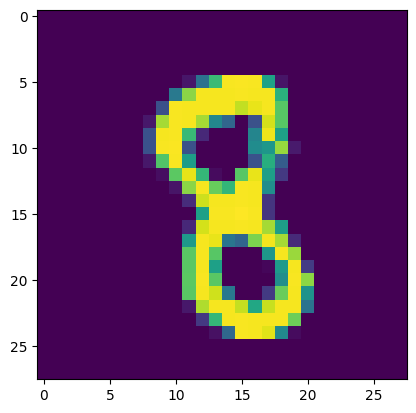

In [166]:
# display an imge
plt.imshow(X[3].view(28,28))
plt.show()

In [167]:
# perturb the image to make it classified as 7
#initialize delta as a random tensor
#delta = torch.zeros_like(X[0].view(-1, 28*28), requires_grad=False)
perturbed_data = create_targeted_adversarial_examples(net, X[3].view(-1, 28*28), y[3], 5, steps=100, epsilon=0.0479)

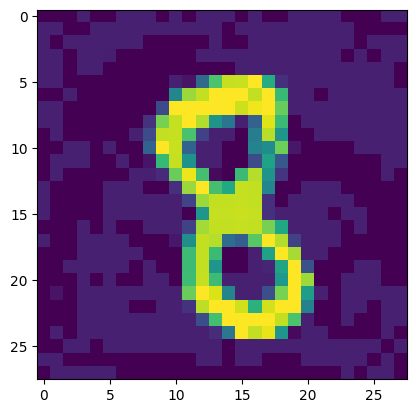

In [168]:
# display the perturbed image
perturbed_data.view(28,28)
plt.imshow(perturbed_data.view(28,28).detach().numpy())
plt.show()

In [170]:
print(net(perturbed_data).argmax())
print(y[3])

tensor(5)
tensor(8)


In [144]:
eps_hat = find_epsilon(net, X[2].view(-1, 28*28), y[2], 5, steps=100, max_iter=10)

In [146]:
# test the epsilon value
perturbed_data = create_targeted_adversarial_examples(net, X[2].view(-1, 28*28), y[2], 5, steps=100, epsilon=eps_hat - 2**(-10))
net(perturbed_data).argmax()

tensor(4)

In [171]:
# create set from m random images of each class in the test set
m = 1
images = []
labels = []
for i in range(10):
    count = 0
    for data in testset:
        X, y = data
        if (y[0] == i):
            images.append(X[0].view(-1, 28*28))
            labels.append(y[0])
            count += 1
        if (count == m):
            break
images = torch.stack(images)
labels = torch.tensor(labels)

# create a dataframe to store the margins and epsilons
margins = []
epsilons = []

# loop through the images
for i in range(10*m):
    clear_output(wait=True)
    print(i)
    # get the margin-epsilon pairs
    margin, epsilon = margin_epsilons(net, images[i], labels[i], steps=100, max_iter=10)
    # add the margin-epsilon pairs to the dataframe
    margins.append(margin)
    epsilons.append(epsilon)

margins = np.array(margins).flatten()
epsilons = np.array(epsilons).flatten()

9


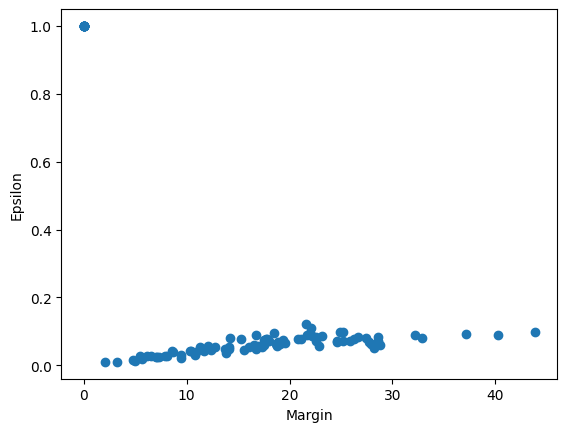

In [173]:
#plot the margins and epsilons
plt.scatter(margins, epsilons)
plt.ylabel("Epsilon")
plt.xlabel("Margin")
plt.show()


In [180]:
# exclude point with margin of 0
new_margins = np.array(margins)
new_epsilons = np.array(epsilons)
new_margins = margins[margins != 0]
new_epsilons = epsilons[margins != 0]

# exclude points with the lowest margin
#new_margins, new_epsilons = new_margins[margins != np.min(margins)], new_epsilons[margins != np.min(margins)]



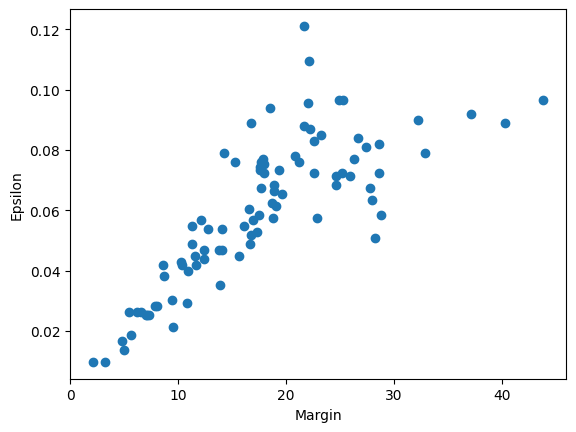

In [181]:
# plot the margins and epsilons
plt.scatter(new_margins, new_epsilons)
plt.ylabel("Epsilon")
plt.xlabel("Margin")
plt.show()

In [183]:
testset

In [188]:
# perturb k random images from the test set to match class 0
k = 100
perturbed_images = []
perturbed_labels = []
i = 0
while (i < k):
    clear_output(wait=True)
    print(i)
    # get a random image from the test set
    idx = np.random.randint(0, len(testset))
    X, y = test[idx]
    if (y == 0):
        continue
    # perturb the image to match class 0
    perturbed_image = create_targeted_adversarial_examples(net, X.view(-1, 28*28), y, 0, steps=100, epsilon=0.1)
    # add the perturbed image to the list
    perturbed_images.append(perturbed_image)
    perturbed_labels.append(y)
    i += 1

perturbed_images = torch.stack(perturbed_images)
perturbed_labels = torch.tensor(perturbed_labels)

99


In [189]:
# test the perturbed images
correct = 0
total = 0
success = 0

with torch.no_grad():
    for i in range(k):
        # forward pass
        output = net(perturbed_images[i].view(-1, 28*28))
        # get the predicted class
        if torch.argmax(output) == perturbed_labels[i]:
            correct += 1
        if torch.argmax(output) == 0:
            success += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))
print("Success rate: ", round(success/total, 3))


Accuracy:  0.02
Success rate:  0.33
